# 情感分析简介 

使用词袋和 SVM 创建简单的情感分析模型

数据集：https://www.kaggle.com/kazanova/sentiment140

In [1]:
import platform
platform.python_version()

'3.9.16'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer

# Additional (not for article)
import datetime
import os

data_path = os.environ.get('pub_data')
# path = '/Users/conorosully/Google Drive/Medium/Sentiment Analysis/Figures/'

from sklearn.model_selection import cross_val_score

In [3]:
# load dataset
data = pd.read_csv(data_path + '/training.1600000.processed.noemoticon.csv',
                    encoding='latin-1',
                    header = None,
                    usecols=[0,5],
                    names=['target','text'])

# random sample
data = data.sample(n=50000,random_state=100).reset_index(drop=True)

print(len(data))
print(sum(data.target==4))
data.head()

50000
24950


,target,text
0,4,@nicholasmw 1 day u will find that girl worry
1,0,there is nothing on tv and im so desperate to ...
2,0,Very excited that greys is on tonight. Not so ...
3,4,2pm's again and again is a great song. Nichkhu...
4,0,My teeth hurt


### Clean dataset

In [4]:
text = data['text'][3]
text = text.lower()
print(text)

2pm's again and again is a great song. nichkhun hwaiting!!! 


In [5]:
def clean_text(text):
    """
    Return cleaned text
    params
    ------------
        text: string
    """

    text = text.lower() # lowercase
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if not t in stopwords] # remove stopwords
    tokens = [t for t in tokens if t.isalnum()] # remove punctuation
    text_clean = " ".join(tokens)
    
    return text_clean

text = data['text'][3]
print(text)
clean_text(text)

2pm's again and again is a great song. Nichkhun hwaiting!!! 


'2pm great song nichkhun hwaiting'

In [6]:
# Examples
print(data.text[1])
print(data.text[12])
print(data.text[18])
print(data.text[21])

print(clean_text(data.text[1]))
print(clean_text(data.text[12]))
print(clean_text(data.text[18]))
print(clean_text(data.text[21]))

there is nothing on tv and im so desperate to be entertained im watching  Hi-5...how sad 
Ugh must go clean the hamsters cage,  oh the joys
So I've been busy all summer. This isn't much of a break for me but at least I'm spendin it doin somethin I love 
Hello world, good morning sunshine. Good to see you again, who me? I'm doing fine! 
nothing tv im desperate entertained im watching sad
ugh must go clean hamsters cage oh joys
busy summer much break least spendin doin somethin love
hello world good morning sunshine good see fine


In [7]:
# clean text 
data['text'] = [clean_text(text) for text in data['text']]

# train test split
train = data[0:40000]
test = data[40000:50000].reset_index(drop=True)

print(len(train),len(test))
data.head()

40000 10000


,target,text
0,4,nicholasmw 1 day u find girl worry
1,0,nothing tv im desperate entertained im watchin...
2,0,excited greys tonight happy season
3,4,2pm great song nichkhun hwaiting
4,0,teeth hurt


### Feature Engineering

In [11]:
# Create count vectoriser 
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)

# Transform training corpus into feature matrix
X = vectorizer.fit_transform(train['text'])
feature_names = vectorizer.get_feature_names_out()

x_train = pd.DataFrame(data=X.toarray(),columns=feature_names)
y_train = train['target']

In [12]:
# Transform testing corpus into feature matrix
X = vectorizer.transform(test['text'])

x_test = pd.DataFrame(data=X.toarray(),columns=feature_names)
y_test = test['target']

In [13]:
# Min-Max scalling
x_max = x_train.max()
x_min = x_train.min()

x_train = (x_train - x_min)/x_max
x_test = (x_test - x_min)/x_max

print(len(x_test))
print(sum(y_test==4))
x_test.head()

10000
5005


,10,100,11,12,15,1st,20,2day,2nd,30,...,yeah,year,years,yep,yes,yesterday,yet,youtube,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelling (SVM)

In [14]:
def svm_kfold(C):
    """
    Returns the k_fold cross-validation accuracy for a given C parameter
    params
    ------------
        C: int
    """
    clf = svm.SVC(kernel='linear', C=C)
    scores = cross_val_score(clf,
                         X = x_train, 
                         y = y_train, 
                         cv=5,
                         n_jobs=-1)
    
    score = round(np.mean(scores),2)
    return score

In [15]:
# tune C hyper-parameter
print("C Parameter:")
for C in [0.001,0.01,0.1,1,10]:
    score = svm_kfold(C)
    print("{}: {}".format(C,score))


C Parameter:
0.001: 0.5
0.01: 0.7
0.1: 0.73
1: 0.73


KeyboardInterrupt: 

In [16]:
begin = datetime.datetime.now()

# fit SVM
model = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)

# get predictions on test set
y_pred = model.predict(x_test)

# accuracy on test set
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {}".format(accuracy))

print(datetime.datetime.now() - begin)

Accuracy: 0.7348
0:24:44.055514


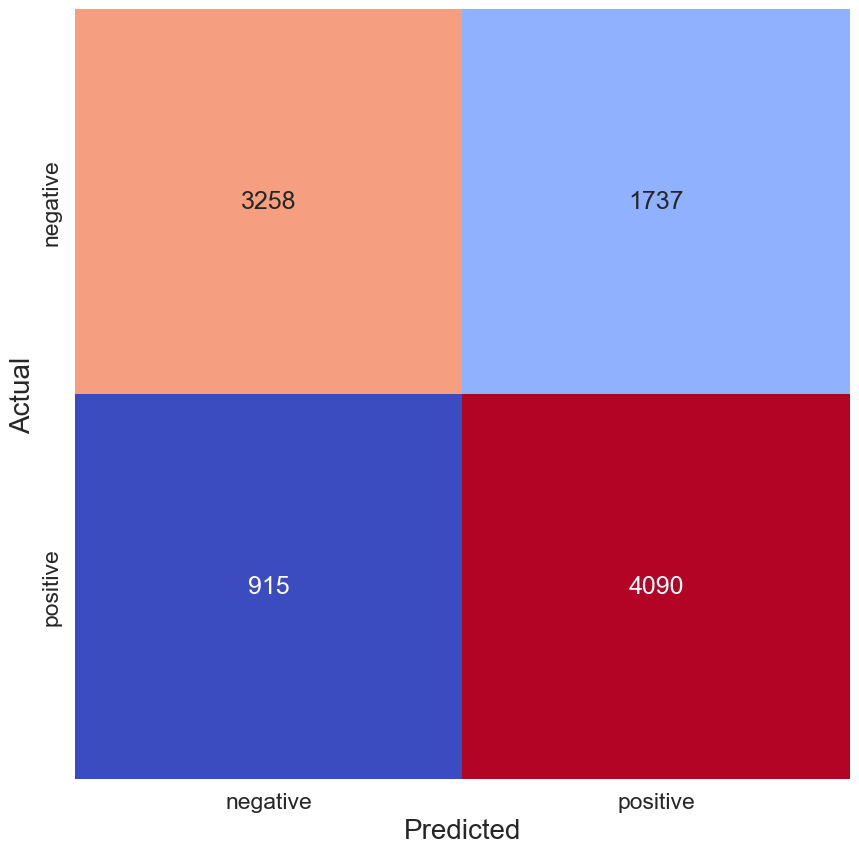

In [18]:
# create confusion matrix
conf_matrix = pd.DataFrame(data = confusion_matrix(y_test,y_pred),
                              columns=['negative','positive'],
                              index=['negative','positive'])

# plot confucion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.ylabel('Actual',size=20)
plt.xlabel('Predicted',size=20)


plt.savefig('../figures/conf_matrix.png',format='png',dpi=150)

### Interpreting the Model

In [19]:
# Find positive coef examples
coef = pd.DataFrame({'feature':feature_names, 'coef': model.coef_[0]})
coef = coef.sort_values('coef',ascending=False)
coef.head()

,feature,coef
129,cant wait,5.415538
988,yay,4.888794
121,ca wait,3.925340
384,happy,3.666561
681,quot,2.721353


In [20]:
# Find negative coef examples
coef = pd.DataFrame({'feature':feature_names, 'coef': model.coef_[0]})
coef = coef.sort_values('coef')
coef.head(10)

,feature,coef
712,sad,-5.953854
949,wish,-5.555572
558,miss,-4.983512
810,sucks,-4.461403
517,lost,-4.167123
387,hate,-4.166974
783,sorry,-4.155369
94,bored,-4.139200
685,raining,-4.063879
128,cant,-3.627557


In [21]:
# Find neutral coef examples 
coef[round(coef.coef,1)==0][0:5]

,feature,coef
414,hoping,-0.047292
781,soooo,-0.043432
845,thought,-0.042895
716,sat,-0.040397
392,headed,-0.039096


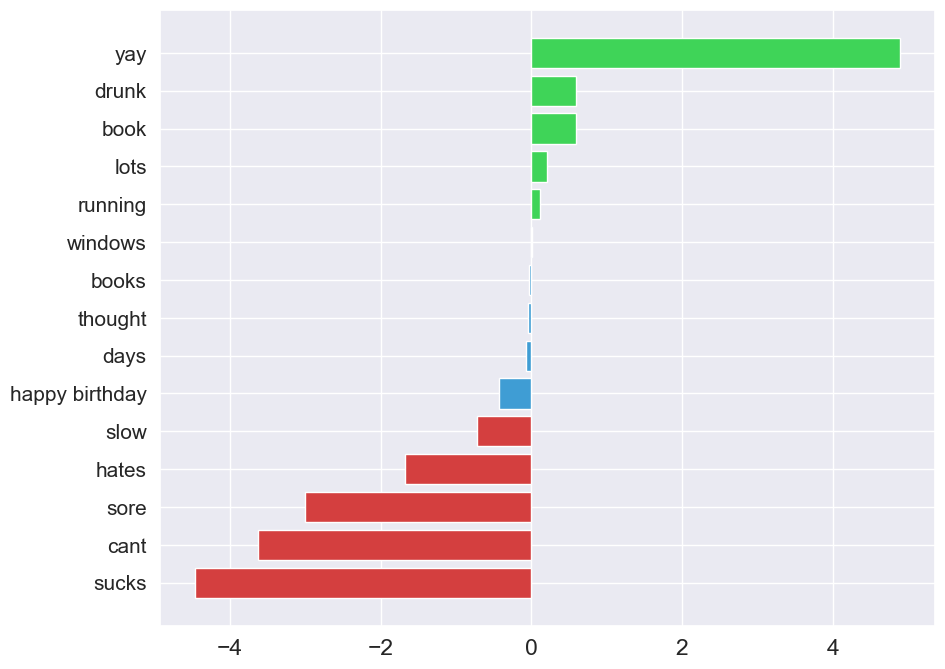

In [22]:
# Create a dataset of model coefs
coef = pd.DataFrame({'feature_names':feature_names, 'coef': model.coef_[0]})

# Get some example coefs
example = coef.loc[[128,988,385,519,769,
                     845,218,948,191,92,
                     711,810,388,782,93]
                    ].sort_values('coef')
# Plot coefs
plt.figure(figsize=(10,8))
ticks = range(len(example))
color = ['#d43f3f']*5 + ['#3f9dd4']*5 + ['#3fd458']*5
plt.barh(ticks, example.coef,color=color, align='center')
plt.yticks(ticks, example.feature_names,size=15)

plt.savefig('../figures/coef_weights.png',format='png',dpi=150)